In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
# from pyarrow import csv
from datetime import datetime 
import numpy as np
import os, random, math, time, shutil
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Modeling
from neuralprophet import NeuralProphet

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else: 
    rc('font', family='AppleGothic')

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import datetime
# from pyarrow import csv
import pickle
import re

# error 함수
def MAPE(y_test, y_pred): return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

In [2]:
def read_file(filename):
    df = pd.read_csv(f'{filename}', encoding="cp949")
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

# Prophet

In [ ]:
filepath = "./data"

In [ ]:
waste = read_file(os.path.join(filepath,'01_음식물쓰레기_FOOD_WASTE_210811_update.csv'))
un = waste[waste.emd_nm=="알수없음"][waste.em_area_cd=='W6Y71C']
un = un.groupby(["base_date"]).sum().reset_index()
un.base_date = pd.to_datetime(un.base_date)
un = un[["base_date", "em_g"]]

...There are no duplicates
shape: (2211445, 8)


In [33]:
un.shape

(352, 2)

In [34]:
un.head()

,base_date,em_g
0,2020-07-13,800
1,2020-07-14,83650
2,2020-07-15,92900
3,2020-07-16,96300
4,2020-07-17,49300


In [35]:
un.columns = ["ds", "y"]
model = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=10, 
                changepoint_prior_scale=0.05, 
                seasonality_mode='multiplicative')
model.fit(un)
future = model.make_future_dataframe(periods=62)
forecast = model.predict(future)

In [36]:
sum_7 = sum(forecast.yhat[len(un):len(un)+31])
sum_8 = sum(forecast.yhat[len(un)+31: ])

In [37]:
sum_7

3522040.2464211835

In [38]:
sum_8

4114212.9910302665

In [39]:
forc = pd.DataFrame(forecast[["ds","yhat"]])
forc = forc.fillna(0)

In [40]:
forc.info()
forc.ds = pd.to_datetime(forc.ds)
forc.index = forc.ds

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      414 non-null    datetime64[ns]
 1   yhat    414 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.6 KB


In [56]:
forcm = forc.resample("M").sum()
forcm['ds']= forcm.index
forcm = forcm.reset_index(drop=True)

In [53]:
un["ds"] = pd.to_datetime(un.ds)
un.index= un.ds
unm = un.resample("M").sum()
unm["ds"]= unm.index
unm = unm.reset_index(drop=True)

In [57]:
forcm = pd.merge(forcm, unm, on=["ds"], how="left")
forcm = forcm[["y", 'yhat', 'ds']]
forcm

,y,yhat,ds
0,"1,354,799.0000","1,340,672.0040",2020-07-31
1,"2,305,600.0000","2,257,169.3715",2020-08-31
2,"1,981,300.0000","2,015,349.1016",2020-09-30
3,"2,183,700.0000","2,093,902.4946",2020-10-31
4,"2,030,300.0000","2,134,369.7260",2020-11-30
5,"2,144,000.0000","2,161,157.9587",2020-12-31
6,"2,046,500.0000","1,999,678.0629",2021-01-31
7,"1,977,750.0000","2,043,897.4795",2021-02-28
8,"2,153,800.0000","2,146,638.0206",2021-03-31
9,"1,932,550.0000","1,877,869.7200",2021-04-30


In [58]:
round(MAPE(forcm.y[:12], forcm.yhat[:12]), 3)

2.151

In [63]:
def double_plot(dat):
    plt.figure(figsize=(15, 5))
    sns.lineplot(x = dat.ds[:12], y = dat.y[:12], label = "Observed", color = "#006699")
    sns.lineplot(x = dat.ds[:12], y = dat.yhat[:12], label = "Forecast", color = "#ff0066")
    plt.title("unknown_pred_prophet")
    plt.show()

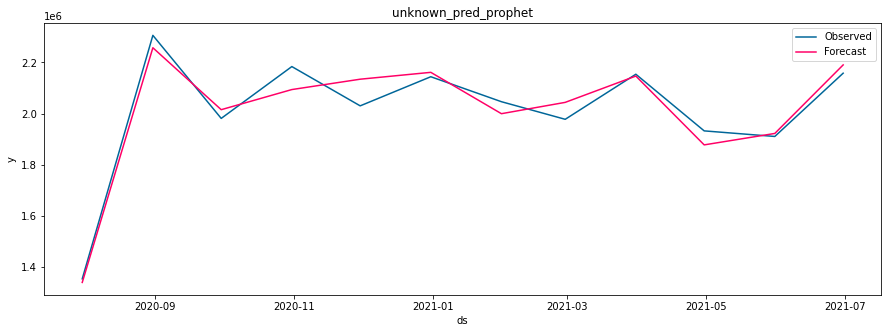

In [64]:
double_plot(forcm)

# 예측

In [5]:
waste = read_file(os.path.join(filepath,'01_음식물쓰레기_FOOD_WASTE_210811_update.csv'))
un = waste[waste.emd_nm=="알수없음"][waste.em_area_cd=='W6Y71C']
un = un.groupby(["base_date"]).sum().reset_index()
un.base_date = pd.to_datetime(un.base_date)
un = un[["base_date", "em_g"]]

...There are no duplicates
shape: (2211445, 8)


In [6]:
un.shape

(352, 2)

In [7]:
un.head()

,base_date,em_g
0,2020-07-13,800
1,2020-07-14,83650
2,2020-07-15,92900
3,2020-07-16,96300
4,2020-07-17,49300


In [8]:
un.columns = ["ds", "y"]
model = NeuralProphet(daily_seasonality=False)
model.fit(un, freq="D")
future = model.make_future_dataframe(un, periods=62, 
                                     n_historic_predictions = len(un))
forecast = model.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 90


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[90/90]: 100%|███████████████████████| 90/90 [00:11<00:00,  7.72it/s, SmoothL1Loss=0.0189, MAE=1.95e+4, RegLoss=0]


In [9]:
sum_7 = sum(forecast.yhat1[len(un):len(un)+31])
sum_8 = sum(forecast.yhat1[len(un)+31: ])

In [10]:
sum_7

2050753.6640625

In [11]:
sum_8

2003748.88671875

In [12]:
forc = pd.DataFrame(forecast[["ds","y","yhat1"]])
forc = forc.fillna(0)

In [5]:
forc.info()
forc.y = forc.y.astype("float")
forc.ds = pd.to_datetime(forc.ds)
forc.index = forc.ds

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      414 non-null    object 
 1   y       414 non-null    int64  
 2   yhat1   414 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.8+ KB


In [6]:
forcm = forc.resample("M").sum()
forcm['ds']= forcm.index

In [8]:
forcm

,y,yhat1,ds
ds,,,
2020-07-31,"1,354,799.0000","1,357,908.0781",2020-07-31
2020-08-31,"2,305,600.0000","2,190,384.2344",2020-08-31
2020-09-30,"1,981,300.0000","2,096,804.8828",2020-09-30
2020-10-31,"2,183,700.0000","2,075,639.0859",2020-10-31
2020-11-30,"2,030,300.0000","2,105,088.7812",2020-11-30
2020-12-31,"2,144,000.0000","2,156,701.4531",2020-12-31
2021-01-31,"2,046,500.0000","2,056,427.7812",2021-01-31
2021-02-28,"1,977,750.0000","1,894,377.1016",2021-02-28
2021-03-31,"2,153,800.0000","2,128,566.9609",2021-03-31


In [7]:
round(MAPE(forcm.y[:12], forcm.yhat1[:12]), 3)

4.036

In [ ]:
def double_plot(dat):
    plt.figure(figsize=(15, 5))
    sns.lineplot(x = dat.index[:12], y = dat.y[:12], label = "Observed", color = "#006699")
    sns.lineplot(x = dat.index[:12], y = dat.yhat1[:12], label = "Forecast", color = "#ff0066")
    plt.title("unknown_pred")
    plt.show()

In [ ]:
double_plot(forcm)